In [1]:
# !pip install numpy
# !pip install tensorflow
# !pip install pillow
# !pip install matplotlib
# !pip install scikit-learn
# !pip install matplotlib tensorflow
# !pip install pydot
# !pip install graphviz


In [2]:
from keras.preprocessing.image import ImageDataGenerator

In [3]:
# All images will be rescaled by 1./255
trin_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [4]:

train_generator = trin_datagen.flow_from_directory(
        'data/train',  
        target_size=(48, 48),  # All images will be resized to 48x48
        batch_size=64, 
        color_mode="grayscale",
        class_mode='categorical')


validation_generator = test_datagen.flow_from_directory(
        'data/test',
        target_size=(48, 48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7168 images belonging to 7 classes.


In [5]:
import cv2
import numpy as np

In [6]:
def denoise_image(image, method):
    if method == "gaussian":
        denoised_image = cv2.GaussianBlur(image, (5, 5), 0)
    elif method == "median":
        denoised_image = cv2.medianBlur(image, 5)
    elif method == "bilateral":
        denoised_image = cv2.bilateralFilter(image, 9, 75, 75)
    elif method == "nl_means":
        denoised_image = cv2.fastNlMeansDenoising(image, h=10, templateWindowSize=7, searchWindowSize=21)
    return denoised_image

In [7]:
def denoised_generator(generator):
    for images, labels in generator:
        denoised_images = []
        for image in images:
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            # Apply non-local means denoising
            denoised_image = denoise_image(gray_image, "nl_means") 
            # Add the denoised image to the list
            denoised_images.append(denoised_image)

        # Convert the list of denoised images back to a numpy array
        denoised_images = np.array(denoised_images)

        yield denoised_images, labels

In [8]:
denoised_train_generator = denoised_generator(train_generator)
denoised_validation_generator = denoised_generator(validation_generator)

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from keras.optimizers import Adam

In [10]:
emotion_model = Sequential()           # layers passing

In [11]:
# 1st convolution layer
emotion_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
emotion_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))

# 2nd convolution layer
emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))

emotion_model.add(Flatten())

# Fully connected layer 1st layer
emotion_model.add(Dense(1024, activation='relu'))
emotion_model.add(Dropout(0.5))

emotion_model.add(Dense(7, activation='softmax')) 

emotion_model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.0001, decay=1e-6),metrics=['accuracy'])

c:\Users\User\anaconda3\envs\fyp_emotion_detection\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [12]:

# training neural network
emotion_model_info = emotion_model.fit(
        train_generator,
        steps_per_epoch=28709 // 64,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=7178 // 64)

Epoch 1/50
448/448 [==============================] - 538s 1s/step - loss: 1.7384 - accuracy: 0.3047 - val_loss: 1.6158 - val_accuracy: 0.3926
Epoch 2/50
448/448 [==============================] - 187s 418ms/step - loss: 1.5582 - accuracy: 0.3988 - val_loss: 1.4670 - val_accuracy: 0.4473
Epoch 3/50
448/448 [==============================] - 187s 418ms/step - loss: 1.4559 - accuracy: 0.4429 - val_loss: 1.3855 - val_accuracy: 0.4827
Epoch 4/50
448/448 [==============================] - 188s 419ms/step - loss: 1.3838 - accuracy: 0.4695 - val_loss: 1.3283 - val_accuracy: 0.5027
Epoch 5/50
448/448 [==============================] - 188s 419ms/step - loss: 1.3288 - accuracy: 0.4940 - val_loss: 1.2901 - val_accuracy: 0.5123
Epoch 6/50
448/448 [==============================] - 188s 419ms/step - loss: 1.2853 - accuracy: 0.5099 - val_loss: 1.2398 - val_accuracy: 0.5367
Epoch 7/50
448/448 [==============================] - 188s 419ms/step - loss: 1.2407 - accuracy: 0.5298 - val_loss: 1.2112 - va

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

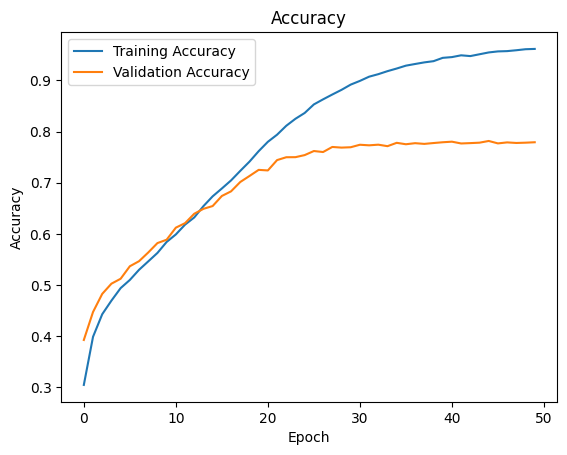

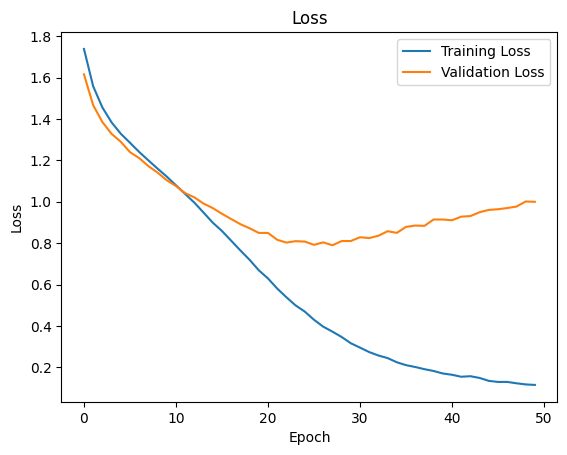

In [15]:
# Load the training history
history = emotion_model_info.history

accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

loss = history['loss']
val_loss = history['val_loss']

plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
# Save model
model_json = emotion_model.to_json()
with open("model/emotion_model.json", "w") as json_file:
    json_file.write(model_json)

In [17]:
# Save weights
emotion_model.save_weights('model/emotion_model.h5')

In [18]:
from keras.models import model_from_json

In [19]:
# Load the model
json_file = open("model/emotion_model.json", "r")
loaded_model_json = json_file.read()
json_file.close()
loaded_emotion_model = model_from_json(loaded_model_json)

loaded_emotion_model.load_weights("model/emotion_model.h5")
print("Loaded model from disk")

Loaded model from disk


In [20]:
test_generator = test_datagen.flow_from_directory(
        'data/test',
        target_size=(48, 48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical',
        shuffle=False)

Found 7168 images belonging to 7 classes.


In [21]:
# Generate predictions on the validation set
y_pred2= loaded_emotion_model.predict_generator(test_generator)

# Convert the predicted probabilities to class labels
y_pred_labels2 = np.argmax(y_pred2, axis=1)

y_true_labels = test_generator.classes

C:\Users\User\AppData\Local\Temp\ipykernel_23688\32490422.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred2= loaded_emotion_model.predict_generator(test_generator)


In [22]:
from sklearn.metrics import confusion_matrix

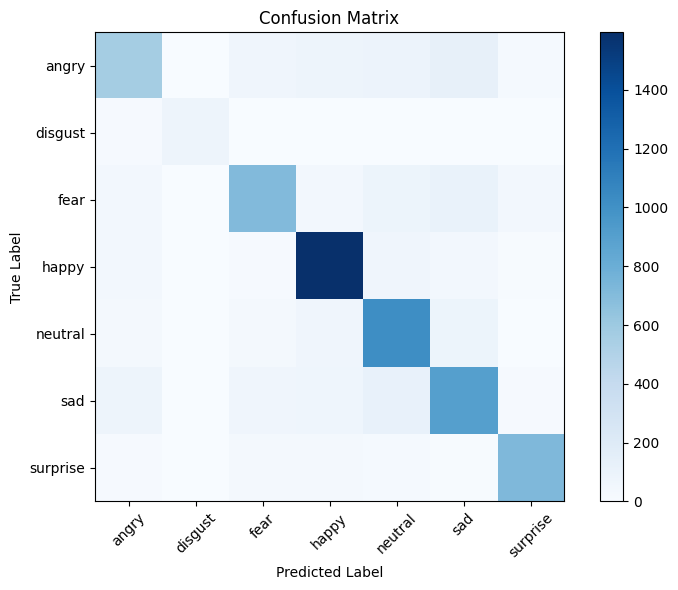

[[ 565    3   63   75   92  128   22]
 [  13   80    3    4    6    4    1]
 [  42    0  705   43   87  106   41]
 [  40    1   18 1596   65   43   11]
 [  36    0   30   65 1017   84    1]
 [  76    2   66   72  117  899   15]
 [  14    0   29   30   23   12  723]]


In [23]:

cm = confusion_matrix(y_true_labels,y_pred_labels2)
class_labels = list(test_generator.class_indices.keys())

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()
print (cm)

In [24]:
# evaluate mmodel
scores = emotion_model.evaluate(validation_generator, verbose=0)
print('Test accuracy', scores[1])

Test accuracy 0.7791573405265808


In [25]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_true_labels,y_pred_labels2))

              precision    recall  f1-score   support

           0       0.72      0.60      0.65       948
           1       0.93      0.72      0.81       111
           2       0.77      0.69      0.73      1024
           3       0.85      0.90      0.87      1774
           4       0.72      0.82      0.77      1233
           5       0.70      0.72      0.71      1247
           6       0.89      0.87      0.88       831

    accuracy                           0.78      7168
   macro avg       0.80      0.76      0.78      7168
weighted avg       0.78      0.78      0.78      7168



In [26]:
from keras.utils.vis_utils import plot_model

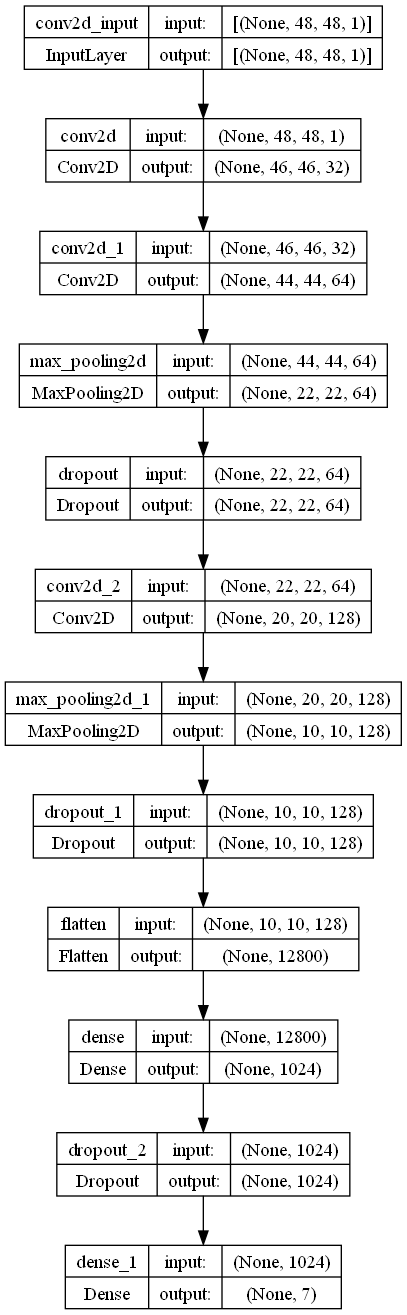

In [27]:
plot_model(emotion_model, to_file='model/model_plot.png', show_shapes=True, show_layer_names=True)